# Exploratory data analysis

## 1. Dataset description

1) Global COVID-19 datasets

- The two COVID-19 datasets, [the global confirmed dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) and [the global death dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), are from the [data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The dataset is updated every day starting from January 22nd, 2020.

- Both datasets contain columns of location information (`Province/State`, `Country/Region`, `Lat`, and `Long`) or daily accumulated numbers of confirmed or deaths in the corresponding location, starting from `1/22/20` to present.

- As stated in the dataset repository, "Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level. The US and other countries are at the country level."

- The datasets combine data from multiple sources and may contain mistakes.



## 2. Load the dataset

In [1]:
import requests, json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats
from scipy.interpolate import interp1d
from pylab import rcParams

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima
from pmdarima.arima import ndiffs

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

SEED = 0
np.random.seed(SEED)

pd.set_option("display.max_rows", 6)
plt.style.use("ggplot")
plt.rcParams.update(
    {
        "font.size": 10,
        #                      'axes.labelweight': 'bold',
        "figure.figsize": (6, 5),
    }
)

Using TensorFlow backend.
C:\Users\flizh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\flizh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\flizh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\flizh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# the following functions are borrowed from https://github.com/TomasBeuzen/machine-learning-tutorials/blob/master/ml-timeseries/notebooks/supervised_time_series_intro.ipynb
# Custom functions
def lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )


def ts_predict(input_data, model, n=20, responses=1):

    predictions = []
    n_features = input_data.size
    for _ in range(n):

        predictions = np.append(
            predictions, model.predict(input_data.reshape(1, -1))
        )  # make prediction
        input_data = np.append(
            predictions[-responses:], input_data[: n_features - responses]
        )  # new input data
    return predictions.reshape((-1, responses))


def plot_ts(ax, df_train, df_test, predictions, xlim, response_cols):
    col_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], "-", c=col_cycle[i], label=f"Train {col}")
        ax.plot(df_test[col], "--", c=col_cycle[i], label=f"Validation {col}")
        ax.plot(
            np.arange(
                df_train.index[-1] + 1, df_train.index[-1] + 1 + len(predictions)
            ),
            predictions[:, i],
            c=col_cycle[-i - 2],
            label=f"Prediction {col}",
        )
    ax.set_xlim(0, xlim + 1)
    ax.set_title(
        f"Train Shape = {len(df_train)}, Validation Shape = {len(df_test)}", fontsize=16
    )
    ax.set_ylabel(df_train.columns[0])


def create_rolling_features(df, columns, windows=[6, 12]):
    for window in windows:
        df["rolling_mean_" + str(window)] = df[columns].rolling(window=window).mean()
        df["rolling_std_" + str(window)] = df[columns].rolling(window=window).std()
        df["rolling_var_" + str(window)] = df[columns].rolling(window=window).var()
        df["rolling_min_" + str(window)] = df[columns].rolling(window=window).min()
        df["rolling_max_" + str(window)] = df[columns].rolling(window=window).max()
        df["rolling_min_max_ratio_" + str(window)] = (
            df["rolling_min_" + str(window)] / df["rolling_max_" + str(window)]
        )
        df["rolling_min_max_diff_" + str(window)] = (
            df["rolling_max_" + str(window)] - df["rolling_min_" + str(window)]
        )

    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    return df

In [3]:
def plot_forecast(train, obs, fc_series, title, lower_series=None, upper_series=None):
    # Plot
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(train.close, label="training")
    plt.plot(obs.close, label="observation")
    plt.plot(fc_series, label="prediction")
    if lower_series is not None:
        plt.fill_between(
            lower_series.index, lower_series, upper_series, color="k", alpha=0.15
        )
    plt.title(f"{title} Observation vs Prediction")
    plt.legend(loc="upper left", fontsize=8)
    plt.show()


def arima_predict(model_fit, num, index, auto=False):

    if not auto:
        # Forecast with 95% conf
        fc, se, conf = model_fit.forecast(num, alpha=0.05)

    else:
        model_fit.plot_diagnostics(figsize=(10, 10))
        plt.show()

        # Forecast
        fc, conf = model_fit.predict(n_periods=int(num), return_conf_int=True)

    # Make as pandas series
    fc_series = pd.Series(fc, index=index)
    lower_series = pd.Series(conf[:, 0], index=index)
    upper_series = pd.Series(conf[:, 1], index=index)

    return fc_series, lower_series, upper_series


def evaluate_model(pred, obs, index):
    scores = {}

    # Mean Absolute Percentage Error
    scores["MAPE"] = [np.mean(np.abs(pred - obs) / np.abs(obs))]

    # Root Mean Squared Error
    scores["RMSE"] = [np.mean((pred - obs) ** 2) ** 0.5]

    scores["Correlation"] = [np.corrcoef(pred, obs)[0, 1]]

    mins = np.amin(np.hstack([pred[:, None], obs[:, None]]), axis=1)
    maxs = np.amax(np.hstack([pred[:, None], obs[:, None]]), axis=1)
    scores["Min-Max Error"] = [1 - np.mean(mins / maxs)]

    return pd.DataFrame(scores, index=[index])


def plot_trans_train(trans_train, trans):

    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(trans_train.close, label="transformed train")

    plt.title(f"Train after differencing and {trans} transformation")
    plt.legend(loc="upper left", fontsize=8)
    plt.show()

In [4]:
def cross_validation(key, n_splits, response_col, trans_train, param_grid):

    regressor = {
        "RandomForestRegressor": RandomForestRegressor(random_state=SEED),
        "KNeighborsRegressor": KNeighborsRegressor(),
        "GradientBoostingRegressor": GradientBoostingRegressor(random_state=SEED),
        "LGBMRegressor": LGBMRegressor(random_state=SEED),
    }
    model = regressor[key]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    l = []
    cv_mean = []
    cv_std = []

    for lag in range(1, 21):

        df_lag = lag_df(trans_train, lag, response_col).dropna()

        cv_score = cross_validate(
            model,
            df_lag.drop(columns=response_col),
            df_lag[response_col[0]],
            cv=tscv,
            scoring="neg_root_mean_squared_error",
        )

        l.append(lag)
        cv_mean.append(round(cv_score["test_score"].mean(), 3))
        cv_std.append(round(cv_score["test_score"].std(), 3))

    results = (
        pd.DataFrame({"lag": l, "cv_mean": cv_mean, "cv_std": cv_std})
        .set_index("lag")
        .sort_values(by="cv_mean", ascending=False)
        .head(5)
    )
    print(results)

    lag = results.index[0]
    df_lag = lag_df(trans_train, lag, response_col).dropna()

    model = GridSearchCV(
        model, param_grid, scoring="neg_root_mean_squared_error", cv=tscv
    )

    model.fit(df_lag.drop(columns=response_col), df_lag[response_col[0]])
    print(f"The best hyperparameters when lag = {lag}:\n{model.best_params_}")
    return model, lag


def regressor_predict(
    model, train_trans, lag, response_col, index, start, log=True, lamb=None
):

    df_lag = lag_df(train_trans, lag, response_col).dropna()

    # starting data for first prediction
    input_data = df_lag.iloc[-1, : lag * train.shape[1]].to_numpy()

    predictions = ts_predict(input_data, model, valid.size)
    if log:
        predict = start * np.exp(np.cumsum(predictions))
    else:
        predict = np.exp(np.log(lamb * (start + np.cumsum(predictions)) + 1) / lamb)
    return pd.Series(predict, index=index)


def analyze_regressor(
    regressor,
    title,
    train,
    test,
    n_splits,
    response_col,
    trans_train,
    param_grid,
    index,
    start,
    log=True,
    lamb=None,
):
    print(
        f'Performing cross-validation to optimzie the lag and',
        f'hyperparameters for the {regressor} regressor ...'
    )
    model, lag = cross_validation(
        regressor, n_splits, response_col, trans_train, param_grid
    )

    predict = regressor_predict(
        model, trans_train, lag, response_col, index, start, log=log, lamb=lamb,
    )

    plot_forecast(train, test, predict, title)
    scores = evaluate_model(predict, test.squeeze(), title)
    return model, scores

In [ ]:
# params = {'function': 'FX_DAILY',
#           'from_symbol': 'CAD',
#           'to_symbol': 'USD',
#           'outputsize': 'full',
#           'apikey': os.environ['ALPHA_API']}

# url = "https://www.alphavantage.co/query"
# response = requests.get(url, params)

# json_data = response.json()

# # Check if the request was successful, if not raise an
# # exception
# if 'Error Message' in list(json_data.keys()):
#     raise Exception("Request failed.")

# # Create the pandas dataframe (see: pd.read_json() )
# data = pd.DataFrame(json_data[list(json_data.keys())[1]]).\
# transpose().apply(pd.to_numeric).reset_index()

# data.columns = ['date', 'open', 'high', 'low', 'close']
# data.date = pd.to_datetime(data.date)

# data.head()

In [2]:
# sub_data =\
# pd.merge(
#     pd.DataFrame(
#         pd.date_range(
#             start='2018-01-01',
#             end='2019-12-31'),
#         columns=['date']),
#     data, how='left')

In [5]:
# sub_data.to_csv('../data/raw_data/cad_to_usd_2018-2019.csv', index=False)
cad_to_usd = pd.read_csv("../data/raw_data/cad_to_usd_2018-2019.csv")

## 3. Explore the dataset

## 4. Initial thoughts


## 5. Wrangling

In [6]:
# data imputation with last observation carried over
cad_to_usd = cad_to_usd.fillna(method="ffill").dropna()
# cad_to_usd = cad_to_usd.set_index('date')
cad_to_usd.head()

,date,open,high,low,close
0,2018-01-01,0.7945,0.7973,0.7943,0.7964
1,2018-01-02,0.7962,0.7998,0.7957,0.7986
2,2018-01-03,0.7986,0.7998,0.7961,0.7972
3,2018-01-04,0.7969,0.8008,0.7959,0.8004
4,2018-01-05,0.8000,0.8090,0.7987,0.8059


Split data into train, valid and test datasets

In [36]:
def split_data(data, split_ratio):

    split_1 = int(data.shape[0] * split_ratio)
    train_valid, test = (
        data.iloc[:split_1],
        data.iloc[split_1:],
    )

    split_2 = int(train_valid.shape[0] * split_ratio)
    train, valid = train_valid.iloc[:split_2], train_valid.iloc[split_2:]

    print(f"The shape of train is {train.shape}")
    print(f"The shape of valid is {valid.shape}")
    print(f"The shape of test is {test.shape}")
    return train, valid, test

In [37]:
train, valid, test = split_data(cad_to_usd[["close"]], 0.95)

The shape of train is (658, 1)
The shape of valid is (35, 1)
The shape of test is (37, 1)


## 6. Research questions



## 7. Data Analysis & Visualizations

Visualize the time series data

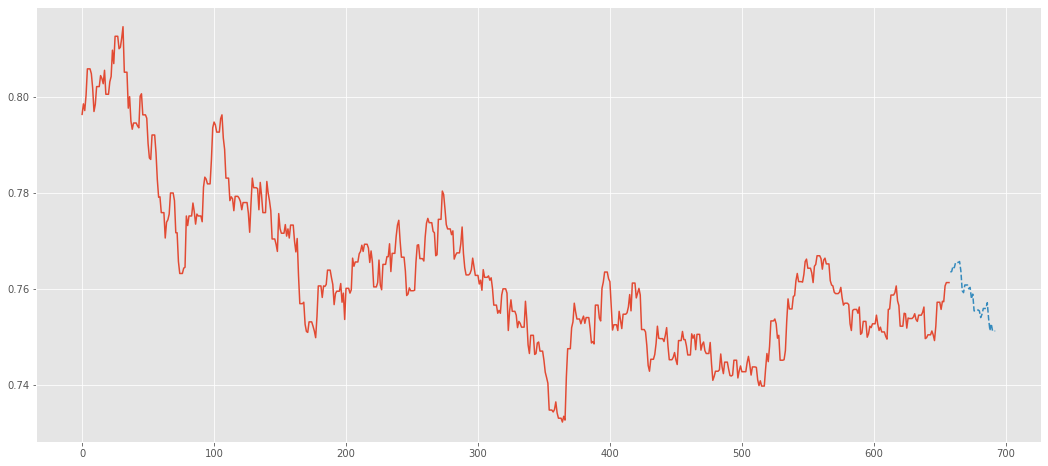

In [10]:
plt.figure(figsize=(18, 8))
plt.plot(train.close, "-")
plt.plot(valid.close, "--")
# plt.plot(test.close, '-')

Decompose the process:

$y_t = T_t + S_t + R_t$

where $y_t$ is the data, $T_t$ is the trend-cycle component, $S_t$ is the seasonal component, and $R_t$ is the remainder component, all at period $t$. 

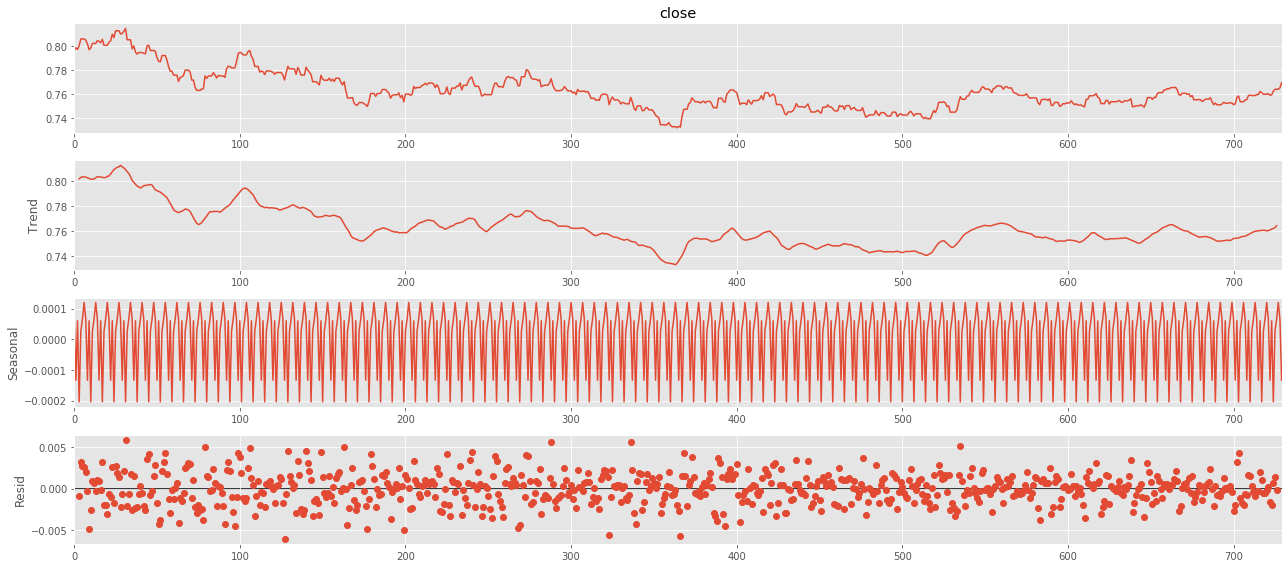

In [11]:
rcParams["figure.figsize"] = 18, 8
decomposition = seasonal_decompose(cad_to_usd.close, period=7, model="additive")
fig = decomposition.plot()
plt.show()

Based on the decomposition results, the process is not stationary.

### 1. ARIMA 

#### 1.1 ARIMA by hand


In [12]:
result = adfuller(train.close)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

ADF Statistic: -2.504658
p-value: 0.114345


The null hypothesis of the ADF test is that the time series is non-stationary. The p-value is bigger than the significance level (0.05). I would try to difference the series.

Find the order of the AR term (p), the order of differencing (d) and the order of the MA term (q) in ARIMA model.


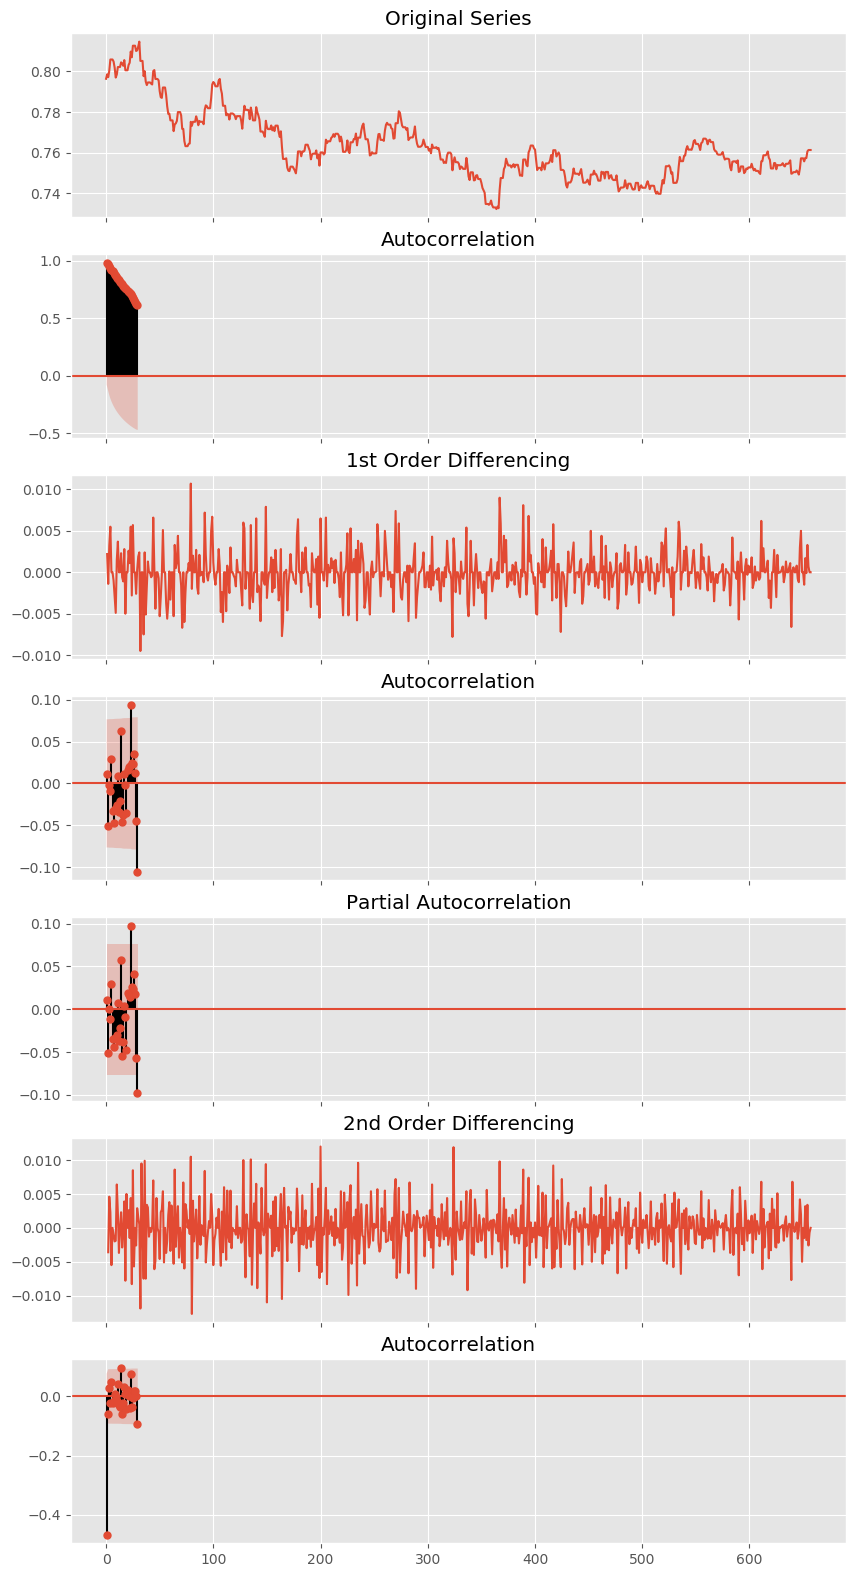

In [13]:
# ref: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

fig, axes = plt.subplots(7, sharex=True, figsize=(10, 20), dpi=100)

# original series
axes[0].plot(train.close)
axes[0].set_title("Original Series")
plot_acf(train.close, ax=axes[1], zero=False)

# 1st Differencing
axes[2].plot(train.close.diff())
axes[2].set_title("1st Order Differencing")
plot_acf(train.close.diff().dropna(), ax=axes[3], zero=False)
plot_pacf(train.close.diff().dropna(), ax=axes[4], zero=False)

# 2nd Differencing
axes[5].plot(train.close.diff().diff())
axes[5].set_title("2nd Order Differencing")
plot_acf(train.close.diff().diff().dropna(), ax=axes[6], zero=False)

plt.show()

The ACF plot of the first order differencing decreases to zero quickly, so I would choose d as 1 and q as 1.

The PACF plot of the first order differencing decreases to zero quickly, so I would choose p as 1.


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  657
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2994.492
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sun, 14 Jun 2020   AIC                          -5980.984
Time:                        11:40:57   BIC                          -5963.033
Sample:                             1   HQIC                         -5974.024
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.342e-05      0.000     -0.531      0.596      -0.000       0.000
ar.L1.D.close    -0.7377      0.260     -2.842      0.004      -1.246      -0.229
ma.L1.D.close     0.7674      0.246     

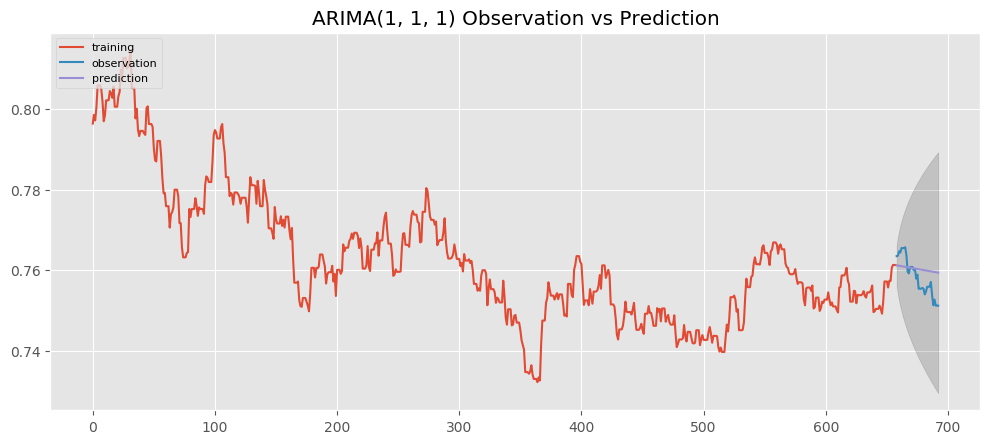

In [14]:
model_1 = ARIMA(train.close, order=(1, 1, 1))
model_1_fit = model_1.fit(disp=-1)
print(model_1_fit.summary())
fc_series, lower_series, upper_series = arima_predict(
    model_1_fit, valid.size, valid.index, auto=False
)
plot_forecast(train, valid, fc_series, "ARIMA(1, 1, 1)", lower_series, upper_series)
scores_1 = evaluate_model(fc_series, valid.squeeze(), "ARIMA(1, 1, 1)")

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  658
Model:                     ARMA(1, 0)   Log Likelihood                2997.956
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sun, 14 Jun 2020   AIC                          -5989.911
Time:                        11:40:57   BIC                          -5976.443
Sample:                             0   HQIC                         -5984.690
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7665      0.008     91.637      0.000       0.750       0.783
ar.L1.close     0.9894      0.006    177.873      0.000       0.979       1.000
                                    Roots       

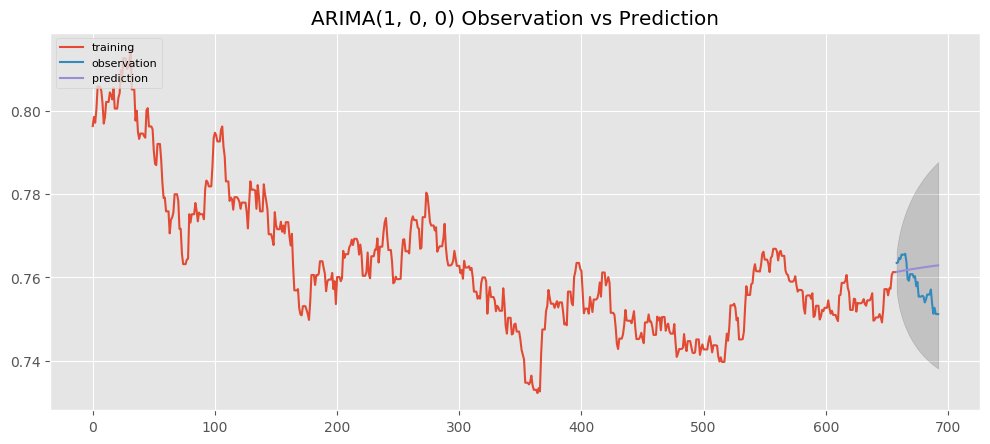

In [15]:
model_2 = ARIMA(train.close, order=(1, 0, 0))
model_2_fit = model_2.fit(disp=-1)
print(model_2_fit.summary())
fc_series, lower_series, upper_series = arima_predict(
    model_2_fit, valid.size, valid.index, auto=False
)
plot_forecast(train, valid, fc_series, "ARIMA(1, 0, 0)", lower_series, upper_series)
scores_2 = evaluate_model(fc_series, valid.squeeze(), "ARIMA(1, 0, 0)")

#### 1.2 Auto ARIMA Forecast

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-5979.994, BIC=-5962.044, Time=0.460 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-5983.715, BIC=-5974.740, Time=0.228 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-5981.793, BIC=-5968.330, Time=0.257 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-5981.795, BIC=-5968.332, Time=0.389 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-5985.424, BIC=-5980.936, Time=0.147 seconds
Total fit time: 1.497 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  658
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2993.712
Date:                Sun, 14 Jun 2020   AIC                          -5985.424
Time:                        11:40:59   BIC                          -5980.936
Sample:                             0   HQIC                 

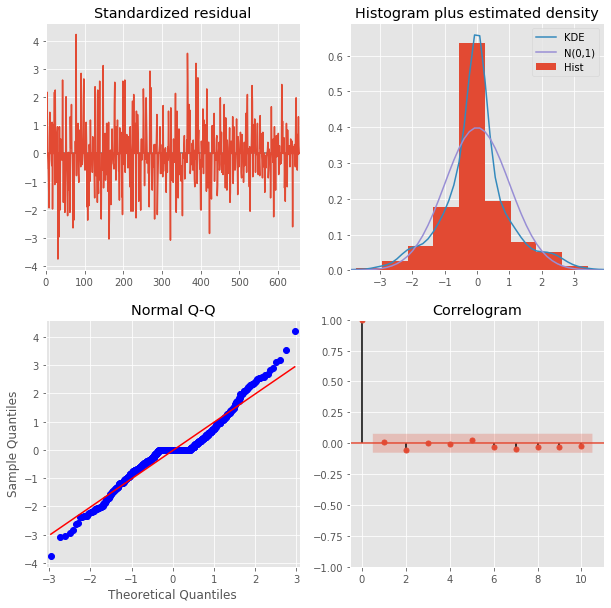

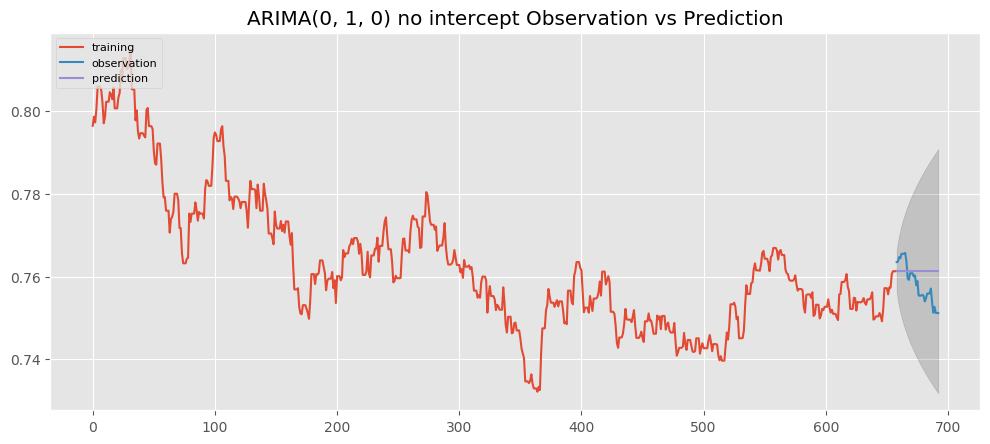

In [16]:
model_3 = pmdarima.auto_arima(
    train["close"],
    start_p=1,
    start_q=1,
    test="adf",
    max_p=3,
    max_q=3,
    m=1,
    d=None,
    seasonal=False,
    start_P=0,
    D=None,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(model_3.summary())
fc_series, lower_series, upper_series = arima_predict(
    model_3, valid.size, valid.index, auto=True
)
plot_forecast(
    train, valid, fc_series, "ARIMA(0, 1, 0) no intercept", lower_series, upper_series
)
scores_3 = evaluate_model(fc_series, valid.squeeze(), "ARIMA(0, 1, 0) no intercept")

#### 1.3 Auto SARIMA Forecast

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=-5781.346, BIC=-5758.953, Time=1.706 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=-4703.276, BIC=-4694.319, Time=0.182 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=-5698.030, BIC=-5680.116, Time=1.593 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=-5223.382, BIC=-5205.468, Time=2.987 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=-4702.121, BIC=-4697.642, Time=0.153 seconds
Fit ARIMA(1,0,1)x(0,1,0,7) [intercept=True]; AIC=-5504.169, BIC=-5486.255, Time=0.779 seconds
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=-5725.194, BIC=-5698.323, Time=2.016 seconds
Fit ARIMA(1,0,1)x(0,1,2,7) [intercept=True]; AIC=-5808.116, BIC=-5781.245, Time=8.188 seconds
Fit ARIMA(1,0,1)x(1,1,2,7) [intercept=True]; AIC=-5808.496, BIC=-5777.146, Time=4.900 seconds
Fit ARIMA(1,0,1)x(2,1,2,7) [intercept=True]; AIC=-5729.508, BIC=-5693.680, Time=2.760 seconds
Fit ARIMA(1,0,1)

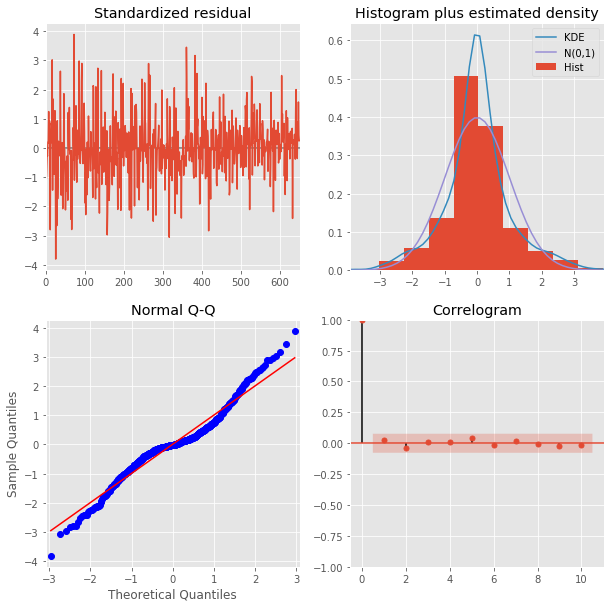

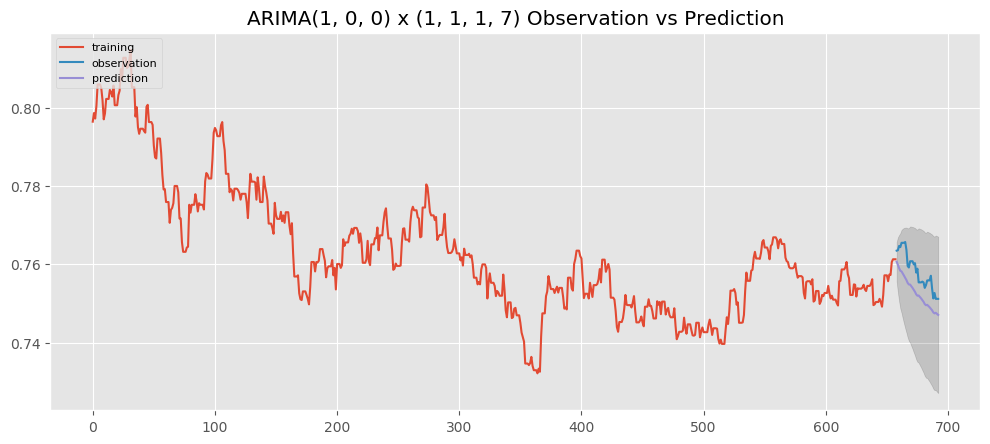

In [17]:
# Seasonal - fit stepwise auto-ARIMA
model_4 = pmdarima.auto_arima(
    train["close"],
    start_p=1,
    start_q=1,
    test="adf",
    max_p=3,
    max_q=3,
    m=7,
    start_P=0,
    seasonal=True,
    d=None,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

model_4.summary()
fc_series, lower_series, upper_series = arima_predict(
    model_4, valid.size, valid.index, auto=True
)
plot_forecast(
    train, valid, fc_series, "ARIMA(1, 0, 0) x (1, 1, 1, 7)", lower_series, upper_series
)
scores_4 = evaluate_model(fc_series, valid.squeeze(), "ARIMA(1, 0, 0) x (1, 1, 1, 7)")

In [18]:
pd.concat(
    [scores_1, scores_2, scores_3, scores_4,]
)

,MAPE,RMSE,Correlation,Min-Max Error
"ARIMA(1, 1, 1)",0.005125,0.004545,9.420275e-01,0.005096
"ARIMA(1, 0, 0)",0.007176,0.006336,-9.416983e-01,0.007110
"ARIMA(0, 1, 0) no intercept",0.006189,0.005470,3.439489e-15,0.006142
"ARIMA(1, 0, 0) x (1, 1, 1, 7)",0.007395,0.005848,9.382922e-01,0.007395


Based on the evaluation scores, ARIMA(1, 1, 1) is the best ARIMA model.

### 2. Classic supervised learning

#### Data transformation

The process is not stationary. A stationary time series has constant mean and variance. I'll remove the trend with differencing to stabilize the mean and use log or Box-Cox transformation to stabilize the variance.

In [19]:
# decide the order of differencing
ndiffs(train)

1

Set the number of differencing to 1.

#### log transformation

In [20]:
log_train = np.log(train).diff().dropna()

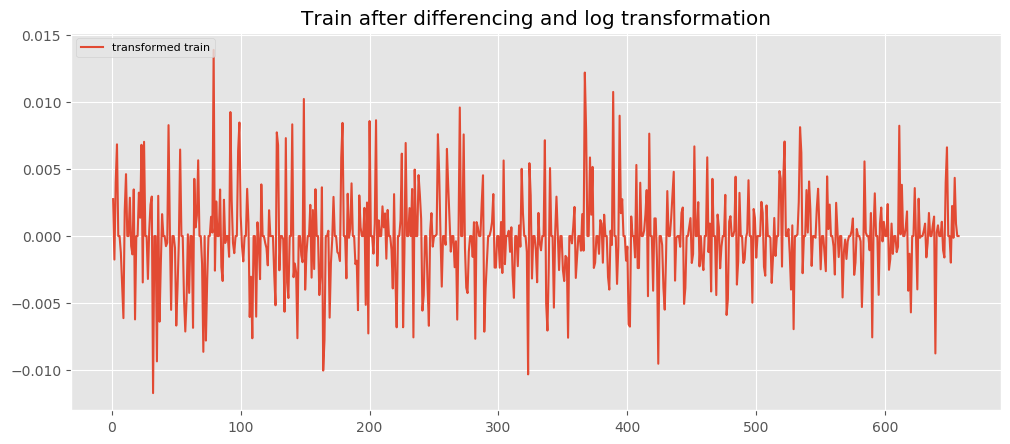

In [21]:
plot_trans_train(log_train, "log")

#### Box-Cox transformation

In [22]:
pre_boxcox_train, lamb = stats.boxcox(train.close)
boxcox_train = pd.DataFrame({"close": pre_boxcox_train}).diff().dropna()
lamb

-16.107706059794832

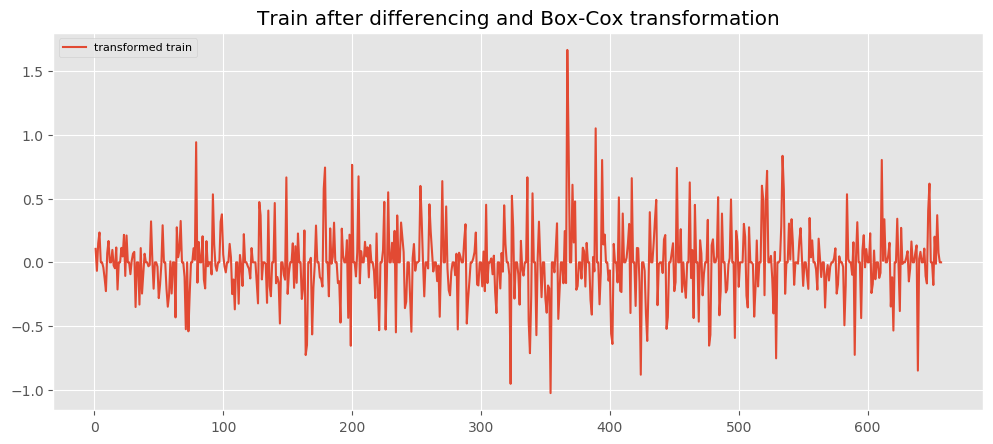

In [23]:
plot_trans_train(boxcox_train, "Box-Cox")

#### 2.1 Random Forests

**Random Forests (log transformation)**

Decide the hyperparameters, `n_estimators` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the RandomForestRegressor regressor ...
     cv_mean  cv_std
lag                 
11    -0.003   0.001
12    -0.003   0.001
19    -0.003   0.001
18    -0.003   0.001
17    -0.003   0.001
The best hyperparameters when lag = 11:
{'n_estimators': 50}


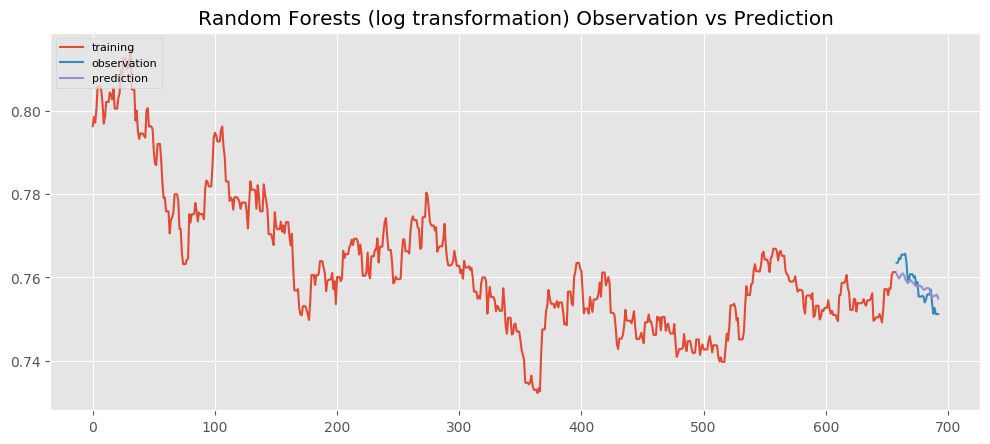

In [24]:
param_grid = {"n_estimators": [10, 50, 100, 150]}
model_5, scores_5 = analyze_regressor(
    "RandomForestRegressor",
    "Random Forests (log transformation)",
    train,
    valid,
    8,
    ["close"],
    log_train,
    param_grid,
    valid.index,
    train.close.iloc[-1],
    log=True,
    lamb=None,
)



**Random Forests (Box-Cox transformation)**

Decide the hyperparameters, `n_estimators` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the RandomForestRegressor regressor ...
     cv_mean  cv_std
lag                 
12    -0.289   0.048
11    -0.290   0.053
8     -0.290   0.045
7     -0.291   0.048
5     -0.292   0.042
The best hyperparameters when lag = 12:
{'n_estimators': 100}


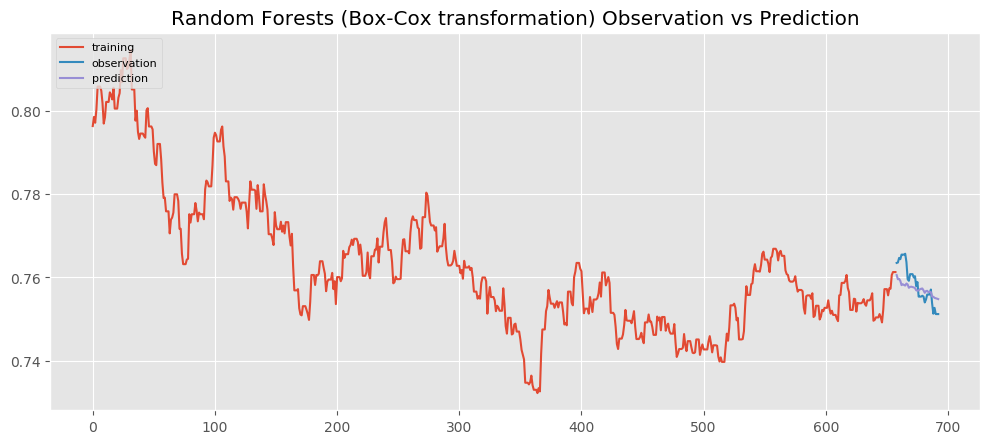

In [25]:
param_grid = {"n_estimators": [10, 50, 100, 150]}
model_6, scores_6 = analyze_regressor(
    "RandomForestRegressor",
    "Random Forests (Box-Cox transformation)",
    train,
    valid,
    8,
    ["close"],
    boxcox_train,
    param_grid,
    valid.index,
    pre_boxcox_train[-1],
    log=False,
    lamb=lamb,
)

In [26]:
pd.concat([scores_5, scores_6])

,MAPE,RMSE,Correlation,Min-Max Error
Random Forests (log transformation),0.003558,0.003093,0.939593,0.003551
Random Forests (Box-Cox transformation),0.004017,0.003641,0.882455,0.004012


The Random Forests (Box-Cox transformation) model gives the best scores.

#### 2.2 k-nearest neighbors


**k-nearest neighbors (log transformation)**

Decide the hyperparameters, `n_neighbors` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the KNeighborsRegressor regressor ...
     cv_mean  cv_std
lag                 
9     -0.003   0.000
1     -0.004   0.001
12    -0.004   0.000
19    -0.004   0.001
18    -0.004   0.001
The best hyperparameters when lag = 9:
{'n_neighbors': 18}


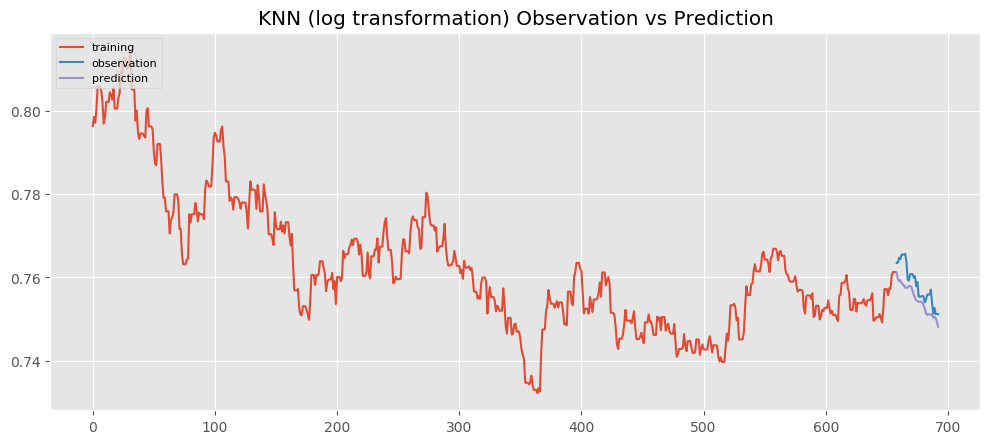

In [27]:
param_grid = {"n_neighbors": list(range(1, 20))}
model_7, scores_7 = analyze_regressor(
    "KNeighborsRegressor",
    "KNN (log transformation)",
    train,
    valid,
    8,
    ["close"],
    log_train,
    param_grid,
    valid.index,
    train.close.iloc[-1],
    log=True,
    lamb=None,
)



**k-nearest neighbors (Box-Cox transformation)**

Decide the hyperparameters, `n_neighbors` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the KNeighborsRegressor regressor ...
     cv_mean  cv_std
lag                 
7     -0.287   0.051
14    -0.288   0.053
16    -0.289   0.051
8     -0.289   0.044
9     -0.292   0.049
The best hyperparameters when lag = 7:
{'n_neighbors': 14}


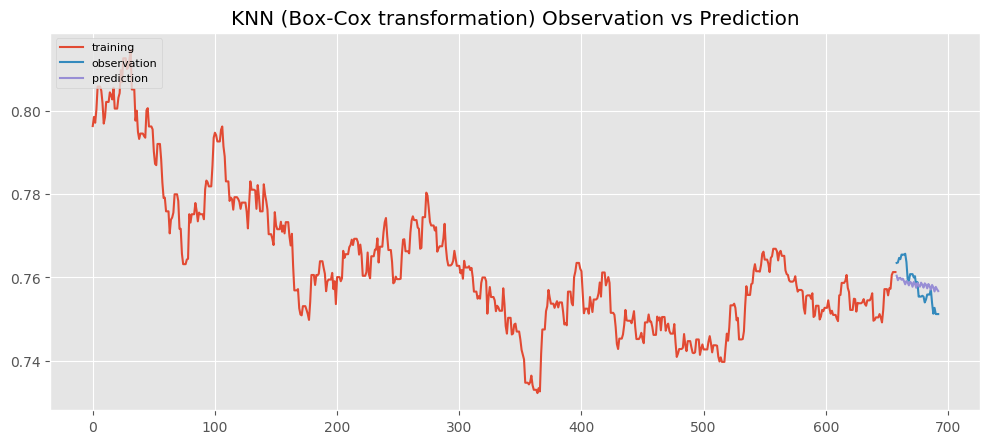

In [28]:
param_grid = {"n_neighbors": list(range(1, 20))}
model_8, scores_8 = analyze_regressor(
    "KNeighborsRegressor",
    "KNN (Box-Cox transformation)",
    train,
    valid,
    8,
    ["close"],
    boxcox_train,
    param_grid,
    valid.index,
    pre_boxcox_train[-1],
    log=False,
    lamb=lamb,
)

In [29]:
pd.concat([scores_7, scores_8])

,MAPE,RMSE,Correlation,Min-Max Error
KNN (log transformation),0.004799,0.004170,0.913180,0.004799
KNN (Box-Cox transformation),0.004489,0.003949,0.781665,0.004476


The Random Forests (Box-Cox transformation) model gives the best scores.

#### 2.3 Gradient Boosting Regressor


**Gradient Boosting Regressor (log transformation)**

Decide the hyperparameters, `n_estimators`, `learning_rate` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the GradientBoostingRegressor regressor ...
     cv_mean  cv_std
lag                 
11    -0.003   0.001
10    -0.003   0.001
19    -0.003   0.001
17    -0.003   0.001
16    -0.003   0.001
The best hyperparameters when lag = 11:
{'learning_rate': 0.001, 'n_estimators': 50}


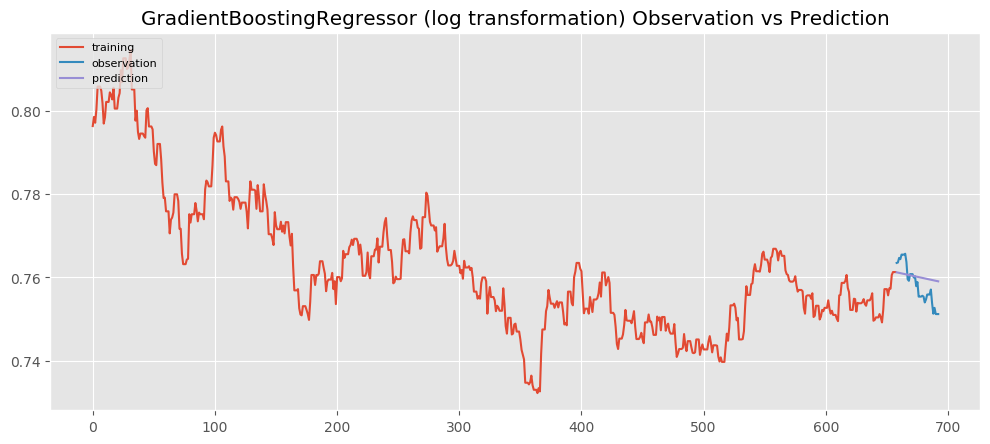

In [30]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 1],
}
model_9, scores_9 = analyze_regressor(
    "GradientBoostingRegressor",
    "GradientBoostingRegressor (log transformation)",
    train,
    valid,
    8,
    ["close"],
    log_train,
    param_grid,
    valid.index,
    train.close.iloc[-1],
    log=True,
    lamb=None,
)



**Gradient Boosting Regressor (Box-Cox transformation)**

Decide the hyperparameters, `n_neighbors` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the GradientBoostingRegressor regressor ...
     cv_mean  cv_std
lag                 
1     -0.298   0.052
2     -0.298   0.049
3     -0.300   0.055
5     -0.302   0.051
12    -0.302   0.057
The best hyperparameters when lag = 1:
{'learning_rate': 0.001, 'n_estimators': 50}


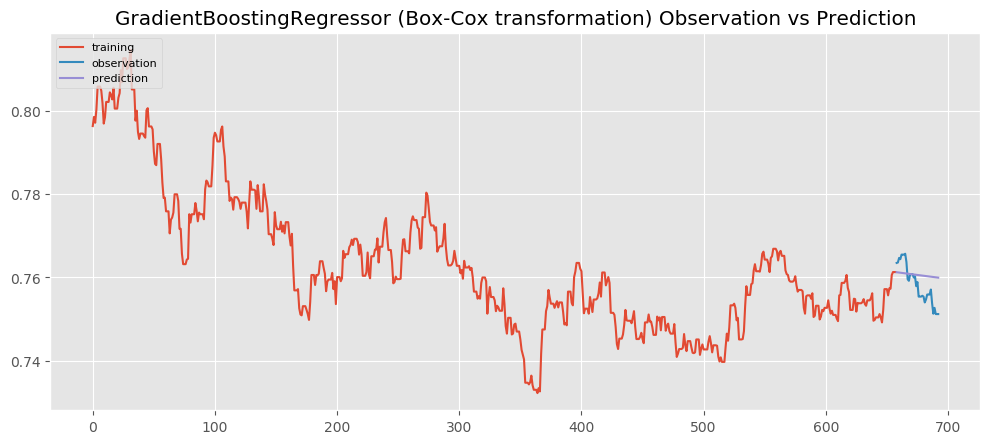

In [31]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 1],
}
model_10, scores_10 = analyze_regressor(
    "GradientBoostingRegressor",
    "GradientBoostingRegressor (Box-Cox transformation)",
    train,
    valid,
    8,
    ["close"],
    boxcox_train,
    param_grid,
    valid.index,
    pre_boxcox_train[-1],
    log=False,
    lamb=lamb,
)


In [32]:
pd.concat([scores_9, scores_10])

,MAPE,RMSE,Correlation,Min-Max Error
GradientBoostingRegressor (log transformation),0.004964,0.004397,0.941851,0.004936
GradientBoostingRegressor (Box-Cox transformation),0.005408,0.004810,0.941919,0.005373


The Random Forests (Box-Cox transformation) model gives the best scores.

#### 2.3 Light GBM Regressor


**Light GBM Regressor (log transformation)**

Decide the hyperparameters, `n_estimators`, `learning_rate` and `lag`, with cross-validation

Performing cross-validation to optimzie the lag and hyperparameters for the LGBMRegressor regressor ...
     cv_mean  cv_std
lag                 
1     -0.003   0.000
3     -0.003   0.000
2     -0.003   0.000
12    -0.004   0.000
19    -0.004   0.001
The best hyperparameters when lag = 1:
{'learning_rate': 0.001, 'n_estimators': 50}


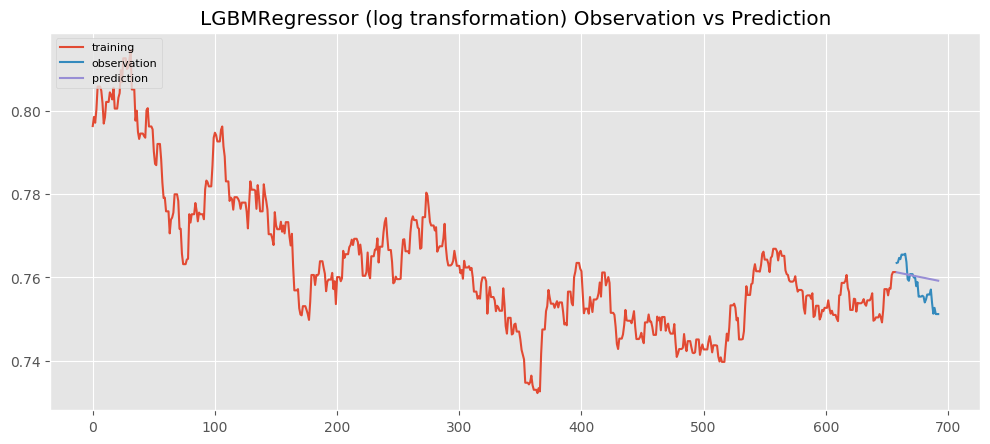

In [33]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 1],
}
model_11, scores_11 = analyze_regressor(
    "LGBMRegressor",
    "LGBMRegressor (log transformation)",
    train,
    valid,
    8,
    ["close"],
    log_train,
    param_grid,
    valid.index,
    train.close.iloc[-1],
    log=True,
    lamb=None,
)



**Light GBM Regressor (Box-Cox transformation)**

Decide the hyperparameters, `n_estimators`, `learning_rate` and `lag`, with cross-validation


Performing cross-validation to optimzie the lag and hyperparameters for the LGBMRegressor regressor ...
     cv_mean  cv_std
lag                 
1     -0.282   0.046
2     -0.290   0.046
7     -0.294   0.052
9     -0.294   0.050
13    -0.295   0.049
The best hyperparameters when lag = 1:
{'learning_rate': 0.001, 'n_estimators': 200}


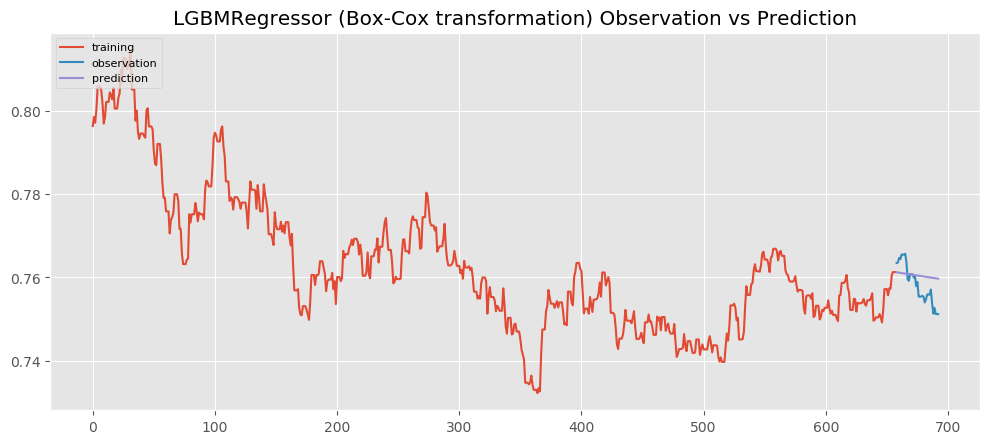

In [34]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 1],
}
model_12, scores_12 = analyze_regressor(
    "LGBMRegressor",
    "LGBMRegressor (Box-Cox transformation)",
    train,
    valid,
    8,
    ["close"],
    boxcox_train,
    param_grid,
    valid.index,
    pre_boxcox_train[-1],
    log=False,
    lamb=lamb,
)


In [35]:
pd.concat(
    [scores_11, scores_12]
)

,MAPE,RMSE,Correlation,Min-Max Error
LGBMRegressor (log transformation),0.005038,0.004466,0.941851,0.005010
LGBMRegressor (Box-Cox transformation),0.005275,0.004687,0.941932,0.005243


### 3. LSTM Recurrent Neural Networks



In [67]:
def reshape_data(data):

    X = np.reshape(data[:, 1:], (data.shape[0], 1, data.shape[1] - 1))
    return X, data[:, 0]

def get_lstm_results(X, y, model, scaler, index):
    # make predictions
    predict = model.predict(X)
    # invert predictions
    predict = scaler.inverse_transform(predict)
    y = scaler.inverse_transform([y])
    # calculate RMSE
    score = np.sqrt(mean_squared_error(y[0], predict[:, 0]))
    fc_series = pd.Series(predict.flatten(), index=index)
    return fc_series, score

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = cad_to_usd[["close"]].copy()
scaled_df['close'] = scaler.fit_transform(cad_to_usd[["close"]])

lag = 3
response_col = ['close']
df_lag = lag_df(scaled_df, lag, response_col).dropna()
train, valid, test = split_data(df_lag, 0.95)

The shape of train is (655, 4)
The shape of valid is (35, 4)
The shape of test is (37, 4)


In [57]:
train_X, train_y = reshape_data(train.to_numpy())
valid_X, valid_y = reshape_data(valid.to_numpy())

In [60]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, lag)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_y, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
3s - loss: 0.0491
Epoch 2/30
2s - loss: 0.0065
Epoch 3/30
2s - loss: 0.0018
Epoch 4/30
2s - loss: 0.0015
Epoch 5/30
2s - loss: 0.0015
Epoch 6/30
2s - loss: 0.0015
Epoch 7/30
2s - loss: 0.0014
Epoch 8/30
3s - loss: 0.0014
Epoch 9/30
3s - loss: 0.0014
Epoch 10/30
5s - loss: 0.0014
Epoch 11/30
4s - loss: 0.0014
Epoch 12/30
3s - loss: 0.0014
Epoch 13/30
3s - loss: 0.0013
Epoch 14/30
4s - loss: 0.0013
Epoch 15/30
3s - loss: 0.0013
Epoch 16/30
3s - loss: 0.0013
Epoch 17/30
2s - loss: 0.0012
Epoch 18/30
2s - loss: 0.0012
Epoch 19/30
2s - loss: 0.0013
Epoch 20/30
2s - loss: 0.0012
Epoch 21/30
2s - loss: 0.0012
Epoch 22/30
2s - loss: 0.0012
Epoch 23/30
2s - loss: 0.0012
Epoch 24/30
2s - loss: 0.0012
Epoch 25/30
2s - loss: 0.0011
Epoch 26/30
2s - loss: 0.0012
Epoch 27/30
2s - loss: 0.0012
Epoch 28/30
2s - loss: 0.0011
Epoch 29/30
2s - loss: 0.0011
Epoch 30/30
2s - loss: 0.0011


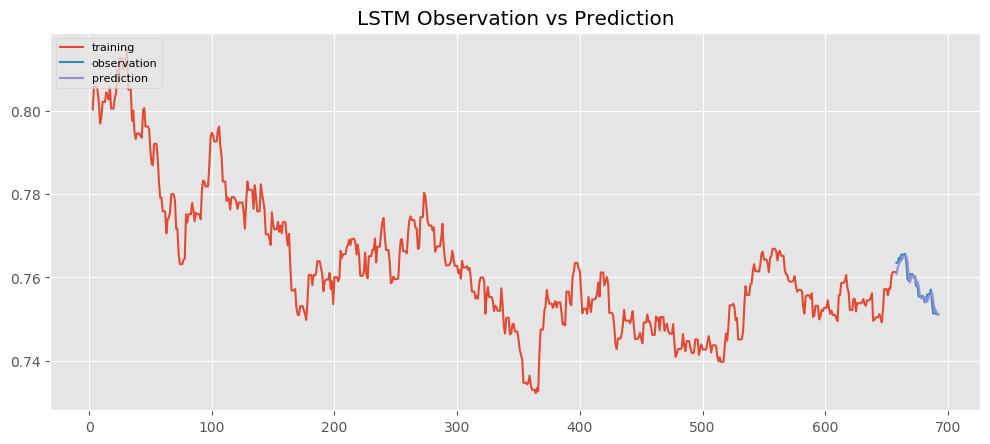

In [75]:
valid_predict, valid_score = get_lstm_results(valid_X, valid_y, model, scaler, valid.index)
inversed_train = train[['close']].copy()
inversed_train['close'] = scaler.inverse_transform(train)
inversed_valid = valid[['close']].copy()
inversed_valid['close'] = scaler.inverse_transform(valid)
plot_forecast(inversed_train, inversed_valid, valid_predict, 'LSTM')

In [73]:
valid_predict

658    0.760822
659    0.762409
660    0.763094
         ...   
690    0.752102
691    0.751472
692    0.751056
Length: 35, dtype: float32

## 8. Summary and conclusions
